## Capstone 2 Proposal: Customer Satisfaction in OList

One of the prominent e-commerce sites for sellers in Brazil is OList, a company that connects merchants and their products to the main marketplaces in the country. In order to maintain a balance in the relationship with merchants and customers they must monitor and maintain a number of different areas of their business such as customer satisfaction, product quality, and delivery performance. Being that OList is a relatively new privately owned company that is up and coming in Brazil, one of the most important factors in maintaining their brand reputation and integrity is customer satisfaction. Since OList connects merchants with customers it is important to identify which products in what areas are contributing to high satisfaction. Similarly, they need to monitor areas of low satisfaction and make decisions on how to manage them.

The purpose of my work will be to analyze customer satisfaction and identify what factors contribute to high and low ratings. What are the highest indicators of whether a product will be successful? What areas of the supply chain correlate most to customer satisfaction? How do successful merchants relate to one another, and similarly with unsuccessful ones? What types of products are most prone to polarizing ratings? When are customers more likely to be satisfied with their purchase? My goal is to use exploratory analysis as a starting point to investigate the overall problem of improving customer satisfaction, and by clearly identifying what areas are most important in determining the outcome of a product's success. 

I eventually want to predict customer satisfaction based on clustering techniques that may identify where more complex commonalities may occur. This can be done with scikit- learn's clustering library for grouping through unsupervised means. My approach will be informed by learnings from the exploratory and statistical analysis phases primarily and will use data from customer reviews and ratings along with merchant-ids and detailed product information. 

The data used is provided by [kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce/data?select=product_category_name_translation.csv) and details all aspects of customer and merchant transactions throughout their database. The data will be loaded from the website onto a local jupyter notebook where I will produce my final product. I plan to provide OList with recommendations of where to focus efforts in order to improve customer satisfaction in specific product areas. This will come in the form of a slide deck and code for reproducibility. 


### Load Data

In [74]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import datetime
import plotly.offline
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
sns.set()

In [75]:
def read_in_data(df_names, directory = './'):
    '''Read in data into seperate dataframes'''
    
    # change directory to data storage location
    os.chdir(directory)
    
    # list of filenames
    extension = 'csv'
    filenames = [i for i in glob.glob('*.{}'.format(extension))]
    
    # create global dfs within function
    for name, file in zip(df_names, filenames):
        globals()[name] = pd.read_csv(file)

In [76]:
# list of prefered dataframe names
df_names = ['sellers', 'translation', 'orders', 'order_items', 'customers', \
                'location', 'payments', 'reviews', 'products']
directory = '/Users/mattmerrill/Springboard/Capstone2/olist_datascience/exploration/olist_data'
read_in_data(df_names, directory)

#### Order Reviews Dataset
This dataset includes data about the reviews made by the customers.

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

In [77]:
def replace_na_with_text(df, column, new_text):
    '''replace missing text with preferred description'''
    
    # change missing data to appropriate label
    df[column] = df[column].replace(np.nan, new_text)

In [78]:
replace_na_with_text(df=reviews, column='review_comment_title', new_text='no title')
replace_na_with_text(df=reviews, column='review_comment_message', new_text='no comment given')

In [79]:
def timestamp_to_datetime(df, columns):
    
    for col in columns:
        df[col] = pd.to_datetime(df[col])

In [80]:
columns = ['review_creation_date', 'review_answer_timestamp']
timestamp_to_datetime(reviews, columns)

In [81]:
def lowercase(df, columns):
    '''change all text to lowercase'''
    for col in columns:
        df[col] = df[col].str.lower()

In [82]:
columns = ['review_comment_title', 'review_comment_title']
lowercase(reviews, columns)

In [83]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,no title,no comment given,2018-01-18,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,no title,no comment given,2018-03-10,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,no title,no comment given,2018-02-17,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,no title,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,no title,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53


#### Order Dataset
This is the core dataset. From each order you might find all other information.

In [84]:
# drop rows containing NaN values, this corresponds to no delivery
#orders.dropna(inplace = True)
    
# drop canceled orders (3 remaining) and reset index
#index_to_drop = orders[orders.order_status == 'canceled'].index
#orders.drop(index_to_drop, inplace=True)
#orders.reset_index(drop=True, inplace=True)

In [85]:
columns_to_datetime = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', \
                          'order_delivered_customer_date', 'order_estimated_delivery_date']
timestamp_to_datetime(orders, columns_to_datetime)

In [86]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
order_id                         99441 non-null object
customer_id                      99441 non-null object
order_status                     99441 non-null object
order_purchase_timestamp         99441 non-null datetime64[ns]
order_approved_at                99281 non-null datetime64[ns]
order_delivered_carrier_date     97658 non-null datetime64[ns]
order_delivered_customer_date    96476 non-null datetime64[ns]
order_estimated_delivery_date    99441 non-null datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [87]:
orders.describe(exclude=object).T

,count,unique,top,freq,first,last
order_purchase_timestamp,99441,98875,2018-03-31 15:08:21,3,2016-09-04 21:15:19,2018-10-17 17:30:18
order_approved_at,99281,90733,2018-02-27 04:31:10,9,2016-09-15 12:16:38,2018-09-03 17:40:06
order_delivered_carrier_date,97658,81018,2018-05-09 15:48:00,47,2016-10-08 10:34:01,2018-09-11 19:48:28
order_delivered_customer_date,96476,95664,2018-05-14 20:02:44,3,2016-10-11 13:46:32,2018-10-17 13:22:46
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522,2016-09-30 00:00:00,2018-11-12 00:00:00


In [88]:
orders.describe(exclude='datetime').T

,count,unique,top,freq
order_id,99441,99441,6c15ee8450a1710e7495723be99f4030,1
customer_id,99441,99441,02b5dc176731821cbf299ba7ac64053c,1
order_status,99441,8,delivered,96478


#### Products Dataset
This dataset includes data about the products sold by Olist.


In [89]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
product_id                    32951 non-null object
product_category_name         32341 non-null object
product_name_lenght           32341 non-null float64
product_description_lenght    32341 non-null float64
product_photos_qty            32341 non-null float64
product_weight_g              32949 non-null float64
product_length_cm             32949 non-null float64
product_height_cm             32949 non-null float64
product_width_cm              32949 non-null float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [90]:
# drop products with no description
products.dropna(inplace = True)
products.reset_index(drop = True, inplace = True)

In [91]:
def translate_column_with_df(df_original, df_translation, column_original, column_translation): 
    '''Translate column, given df with translation'''
    
    # convert translation to dictionary to extract key, value pairs
    df_translation = df_translation.set_index(column_original)
    df_translation = df_translation.to_dict('dict')
    
    # map translations
    df_original[column_original] = df_original[column_original]\
                                               .map(df_translation[column_translation])

In [92]:
translate_column_with_df(products, translation, 'product_category_name', 'product_category_name_english')

In [93]:
products.describe(exclude=float).T

,count,unique,top,freq
product_id,32340,32340,aca71e1fceaea4278f27aab8a3498f60,1
product_category_name,32327,71,bed_bath_table,3029


> Over 32,000 products within 71 categories

In [94]:
products.describe(exclude=object).T

,count,mean,std,min,25%,50%,75%,max
product_name_lenght,32340.0,48.476592,10.245699,5.0,42.0,51.0,57.0,76.0
product_description_lenght,32340.0,771.492393,635.124831,4.0,339.0,595.0,972.0,3992.0
product_photos_qty,32340.0,2.188961,1.736787,1.0,1.0,1.0,3.0,20.0
product_weight_g,32340.0,2276.956586,4279.291845,0.0,300.0,700.0,1900.0,40425.0
product_length_cm,32340.0,30.854545,16.955965,7.0,18.0,25.0,38.0,105.0
product_height_cm,32340.0,16.958813,13.636115,2.0,8.0,13.0,21.0,105.0
product_width_cm,32340.0,23.208596,12.078762,6.0,15.0,20.0,30.0,118.0


#### Sellers Dataset
This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.

In [95]:
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [96]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
seller_id                 3095 non-null object
seller_zip_code_prefix    3095 non-null int64
seller_city               3095 non-null object
seller_state              3095 non-null object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


#### Customers Dataset
This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.

At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.

In [97]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [98]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null int64
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


#### Order Items Dataset
This dataset includes data about the items purchased within each order.

In [99]:
timestamp_to_datetime(order_items, ['shipping_limit_date'])

In [100]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [101]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
order_id               112650 non-null object
order_item_id          112650 non-null int64
product_id             112650 non-null object
seller_id              112650 non-null object
shipping_limit_date    112650 non-null datetime64[ns]
price                  112650 non-null float64
freight_value          112650 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 6.0+ MB


#### Geolocation Dataset
This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.

In [102]:
location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
geolocation_zip_code_prefix    1000163 non-null int64
geolocation_lat                1000163 non-null float64
geolocation_lng                1000163 non-null float64
geolocation_city               1000163 non-null object
geolocation_state              1000163 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [103]:
location.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [104]:
location.geolocation_zip_code_prefix.nunique()

19015

> location data seems to have many duplicates with miniscule lat and lng variations between each. Keeping only the first of each zip code will help avoid merge issues later on.

In [105]:
location.drop_duplicates(subset = ['geolocation_zip_code_prefix'], keep = 'first', inplace = True)

In [106]:
location.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19015 entries, 0 to 999846
Data columns (total 5 columns):
geolocation_zip_code_prefix    19015 non-null int64
geolocation_lat                19015 non-null float64
geolocation_lng                19015 non-null float64
geolocation_city               19015 non-null object
geolocation_state              19015 non-null object
dtypes: float64(2), int64(1), object(2)
memory usage: 891.3+ KB


#### Payments Dataset
This dataset includes data about the orders payment options.

In [107]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
order_id                103886 non-null object
payment_sequential      103886 non-null int64
payment_type            103886 non-null object
payment_installments    103886 non-null int64
payment_value           103886 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [108]:
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


### Combine data into 3 dataframes

In order to analyze customer ratings and seller influences, we will combine the data into dataframes related to their respective content.

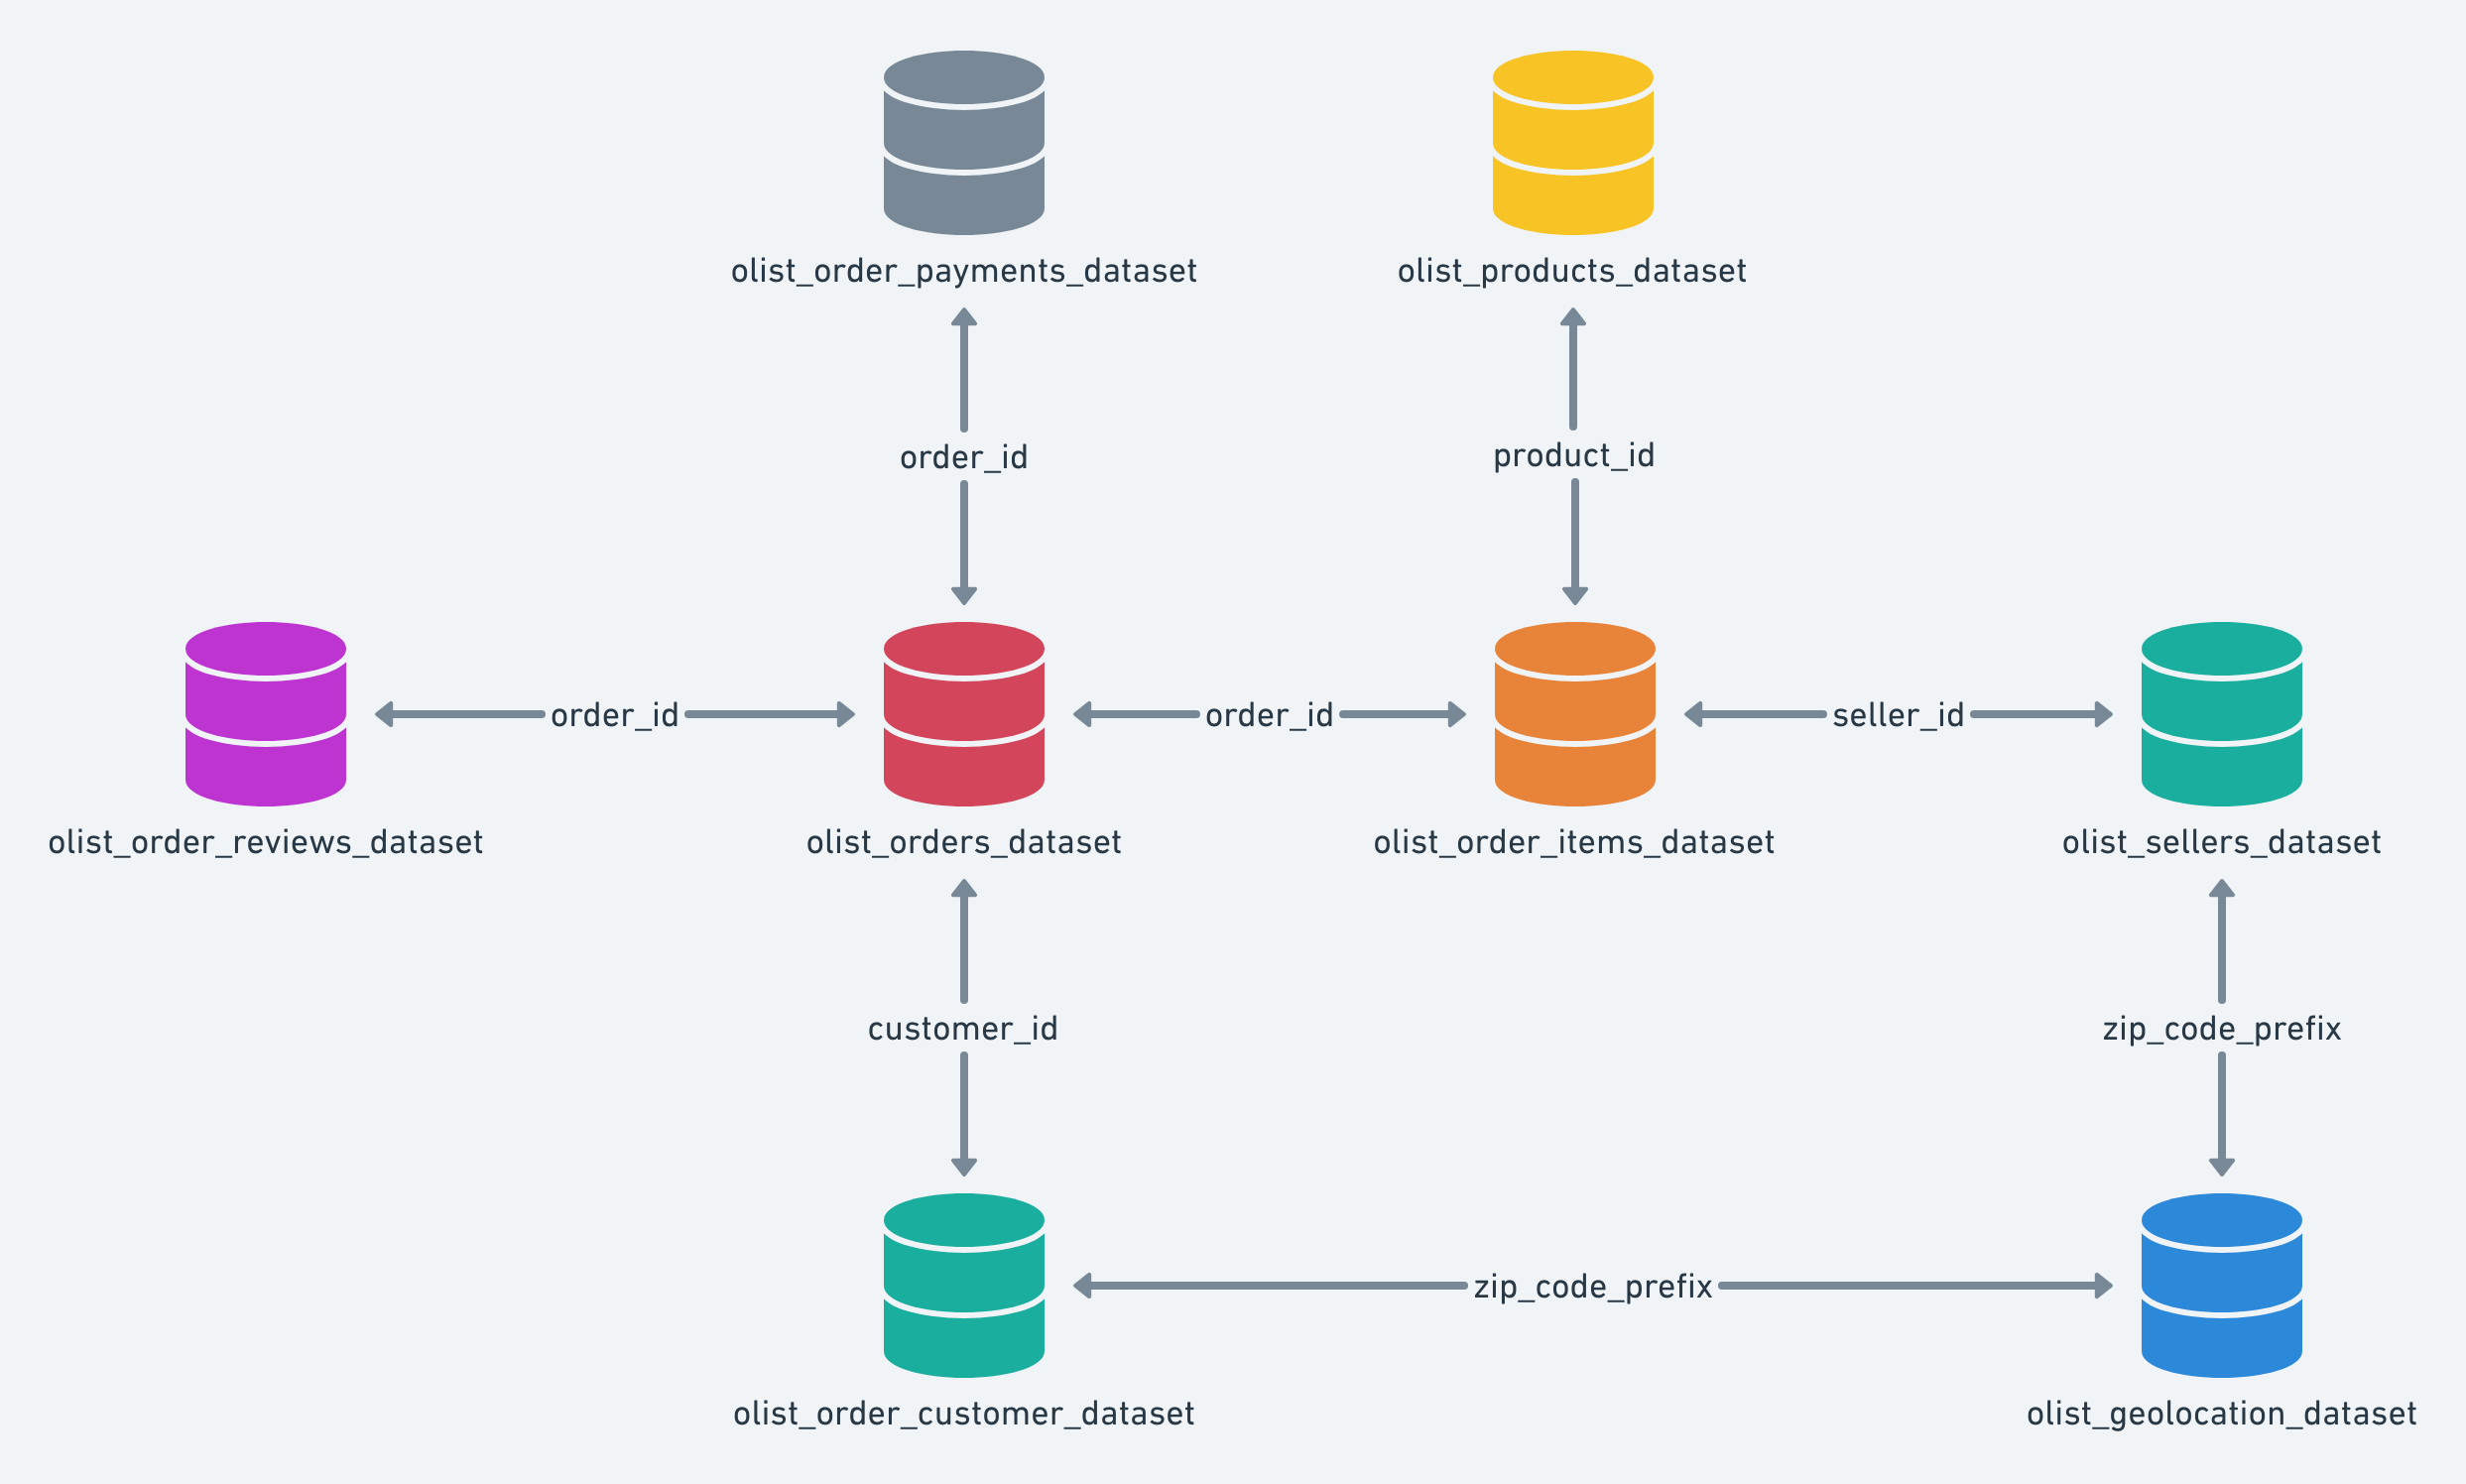


In [109]:
def merge_multiple_df_on_key(dfs, key):
    '''create dataframe with customer info including their location, order details and review'''
    
    from functools import reduce
    
    # stolen from https://stackoverflow.com/questions/23668427/pandas-three-way-joining-multiple-dataframes-on-columns)
    new_df = reduce(lambda left,right: pd.merge(left,right, how = 'inner', on=key), dfs)
    
    return new_df

In [110]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [111]:
# dfs to merge with order_id column
dfs = [orders, order_items, reviews]
# merge on key
customer_purchases = merge_multiple_df_on_key(dfs, key = 'order_id')

In [112]:
def drop_duplicates_ignore_cols(df, cols_to_ignore, keep = 'first'):
    '''drop duplicates but ignore certain columns'''
    df.drop_duplicates(keep = keep, \
                       subset=df.columns.difference(cols_to_ignore), \
                       inplace=True)

In [113]:
# drop duplicate rows based on all columns except these
cols_to_ignore = ['review_id', 'review_answer_timestamp', 'review_creation_date']

# call function
drop_duplicates_ignore_cols(customer_purchases, cols_to_ignore)

In [114]:
# drop order delivery details, this will go into the seller_info df
cols_to_drop = orders.columns.difference(['order_id', 'customer_id', 'order_purchase_timestamp', \
                                          'order_delivered_customer_date', 'order_estimated_delivery_date'])
customer_purchases.drop(cols_to_drop, 1, inplace=True)

In [115]:
# set cols to drop after merging with location and customers
cols_to_drop = ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state']
    
# merge with customers and location
customer_info = pd.merge(pd.merge(customer_purchases, customers, on = 'customer_id'), location, \
                             left_on ='customer_zip_code_prefix', \
                             right_on = 'geolocation_zip_code_prefix').drop(cols_to_drop, 1).reset_index(drop=True)

In [116]:
# need to merge product info to pull the product_category_name
customer_info = customer_info.merge(products, on = 'product_id')

In [117]:
# merge all dfs associated with seller
seller_info = pd.merge(pd.merge(pd.merge(pd.merge(order_items, \
                        sellers, on = 'seller_id'), \
                        products, on = 'product_id'), \
                        reviews, on = 'order_id'), \
                        location, how = 'inner', \
                                  left_on ='seller_zip_code_prefix', \
                                  right_on = 'geolocation_zip_code_prefix')

In [118]:
# drop redundant and unnecessary columns
cols_to_drop = ['geolocation_zip_code_prefix', 'geolocation_city', 'geolocation_state', 'freight_value']
seller_info.drop(cols_to_drop, 1, inplace=True)
seller_info.reset_index(drop=True, inplace=True)

In [119]:
cols_to_ignore = ['review_id', 'review_answer_timestamp', 'review_creation_date']
drop_duplicates_ignore_cols(seller_info, cols_to_ignore)

In [120]:
seller_info.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,seller_zip_code_prefix,seller_city,seller_state,product_category_name,...,product_height_cm,product_width_cm,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,geolocation_lat,geolocation_lng
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,97ca439bc427b48bc1cd7177abe71365,5,no title,"Perfeito, produto entregue antes do combinado.",2017-09-21,2017-09-22 10:57:03,-22.498183,-44.123614
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,b11cba360bbe71410c291b764753d37f,5,no title,"lannister como sempre, entregou certinho e den...",2017-07-14,2017-07-17 12:50:07,-22.498183,-44.123614
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05,2018-06-06 21:41:12,-22.498183,-44.123614
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,8304ff37d8b16b57086fa283fe0c44f8,5,no title,no comment given,2017-08-10,2017-08-13 03:35:17,-22.498183,-44.123614
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,27277,volta redonda,SP,cool_stuff,...,9.0,14.0,426f43a82185969503fb3c86241a9535,5,no title,no comment given,2017-08-25,2017-08-28 00:51:18,-22.498183,-44.123614


In [121]:
# set dfs to have common orders between them
sellers = seller_info[seller_info.order_id.isin(customer_info.order_id)]
customers = customer_info[customer_info.order_id.isin(seller_info.order_id)]

In [122]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110894 entries, 0 to 111452
Data columns (total 25 columns):
order_id                      110894 non-null object
order_item_id                 110894 non-null int64
product_id                    110894 non-null object
seller_id                     110894 non-null object
shipping_limit_date           110894 non-null datetime64[ns]
price                         110894 non-null float64
seller_zip_code_prefix        110894 non-null int64
seller_city                   110894 non-null object
seller_state                  110894 non-null object
product_category_name         110870 non-null object
product_name_lenght           110894 non-null float64
product_description_lenght    110894 non-null float64
product_photos_qty            110894 non-null float64
product_weight_g              110894 non-null float64
product_length_cm             110894 non-null float64
product_height_cm             110894 non-null float64
product_width_cm            

In [123]:
sellers = sellers.dropna(subset = ['product_category_name']).reset_index(drop=True)
customers = customers.dropna(subset=['product_category_name']).reset_index(drop=True)

## Plot sellers and customer as graph

In [124]:
import geopandas as gpd
from shapely.geometry import Point, Polygon

'''seller_geometry = [Point(xy) for xy in zip(seller_info.geolocation_lng, seller_info.geolocation_lat)]
customer_geometry = [Point(xy) for xy in zip(customer_info.geolocation_lng, customer_info.geolocation_lat)]'''

'seller_geometry = [Point(xy) for xy in zip(seller_info.geolocation_lng, seller_info.geolocation_lat)]\ncustomer_geometry = [Point(xy) for xy in zip(customer_info.geolocation_lng, customer_info.geolocation_lat)]'

# Exploratory Data Analysis

### Which product type generated the most profit?

In [125]:
def filter_by_count(df, column, count):
    
    new_df = df.groupby(column).filter(lambda x: len(x) > count)
    
    return new_df

In [126]:
def plot_filtered_groupby(df, groupby_col, sort_col, count, agg_func):
    
    df_filtered = filter_by_count(df, groupby_col, count)\
                         [[groupby_col, sort_col]]\
    
    df_agg = df_filtered.groupby([groupby_col])[sort_col]\
                        .apply(agg_func)\
                        .reset_index()\
                        .sort_values([sort_col], ascending = False)
    
    fig, ax = plt.subplots(figsize=(8, 12))
    
    ax = sns.barplot(data=df_agg, x=sort_col, y=groupby_col, color = 'cyan')
    plt.show()

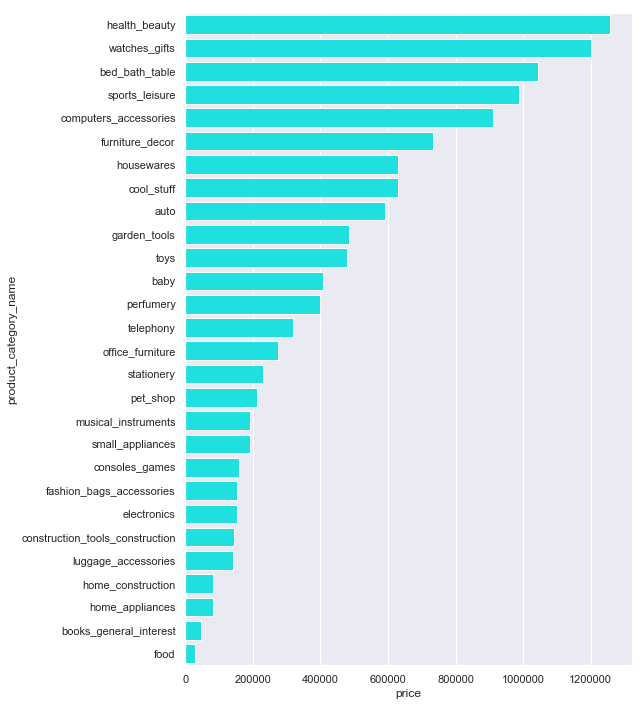

In [127]:
plot_filtered_groupby(customers, 'product_category_name', 'price', 500, sum)

> It looks like heath and beauty, watches, bed and bath, sports leisure and computer accessories round out the top 5 most profittable product categories. Does this correlate the the price or simply the populatiry of the items? 

### Which product has the highest average cost for the customer?

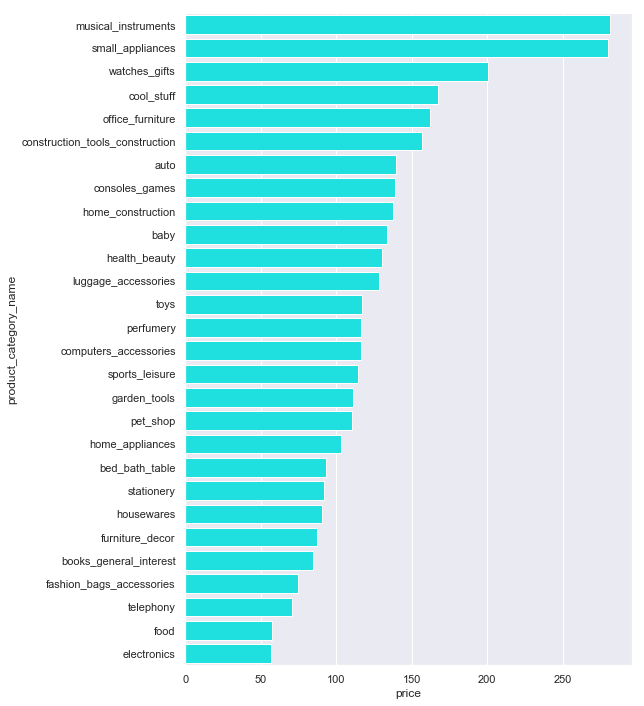

In [128]:
plot_filtered_groupby(customers, 'product_category_name', 'price', 500, np.mean)

> The top 5 highest average cost product categories do not overlap with the highest profit categories. Falling just out of the top 5 average cost products is watches. This is an important product to maintain customer satisfaction for by possibly prioritizing on time deliveries. 

### What are the highest rated products?

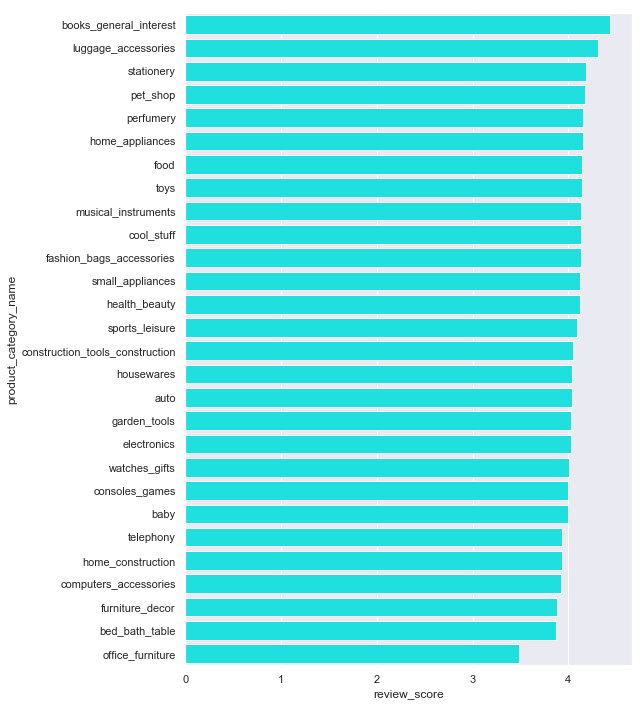

In [129]:
plot_filtered_groupby(customers, 'product_category_name', 'review_score', 500, np.mean)

> It looks like many of the highest grossing products fall on the lower end of the average review score with the exception of health and beauty, and sports leisure. 

### Which products are purchased most frequently?

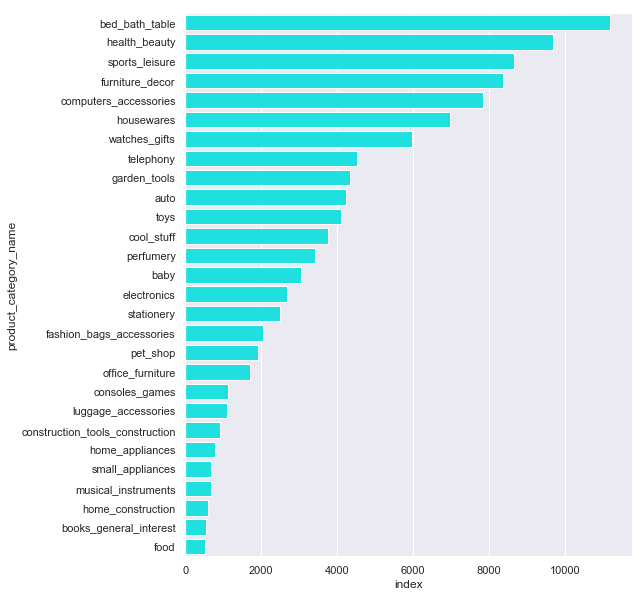

In [130]:
df_filtered = filter_by_count(customers, 'product_category_name', 500)['product_category_name'].reset_index()
    
df_agg = df_filtered.groupby(['product_category_name'])\
                              .count().sort_values(['index'], ascending = False)\
                              .reset_index()

fig, ax = plt.subplots(figsize=(8, 10))
    
ax = sns.barplot(data=df_agg, x='index', y='product_category_name', color = 'cyan')
plt.show()

## Exploring Seasonal Trends

### When is Olist receiving the most profit?

In [131]:
def timeseries_plot(df, timeseries_col, y_col, agg_func, dStart, dEnd, sample_by = 'D'):
    
    timeseries_vs_y = df[[timeseries_col, y_col]]
    plot_df = timeseries_vs_y.set_index(timeseries_col).resample(sample_by)[y_col].apply(agg_func)
    df = plot_df[(dStart <= plot_df.index) & (plot_df.index <= dEnd)]

    ax = plt.figure(figsize=(12, 6)).add_subplot(111)   
    xticks = pd.date_range(start=dStart, end=dEnd, freq='M')

    df.plot(ax = ax, xticks = xticks)

    ax.set_xticklabels([x.strftime('%h\n%Y') for x in xticks])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
 
    plt.show()

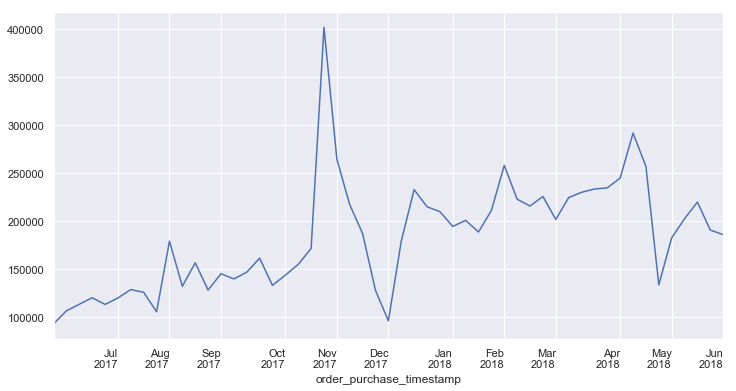

In [132]:
# Total profit over 
dStart = datetime.datetime(2017,7,1) # 1 May
dEnd = datetime.datetime(2018,7,1) # 1 July
timeseries_plot(customers, 'order_purchase_timestamp', 'price', sum, dStart, dEnd, 'W')

> There is an uptick in profit in late November, most definitely corresponding to gifts for the Christmas season. There are local peaks at the end of February and the beginning of May as well with sharp drops in profit near January 1st and towards the end of May. In Brazil, the well known Carnival festival falls towards the end of February, possibly corresponding to the increase in profit. It is not clear why there is such a sharp increase in profit in early May. This is something to continue investigating. 

### How do review scores change over time? Are there connections to national holidays?

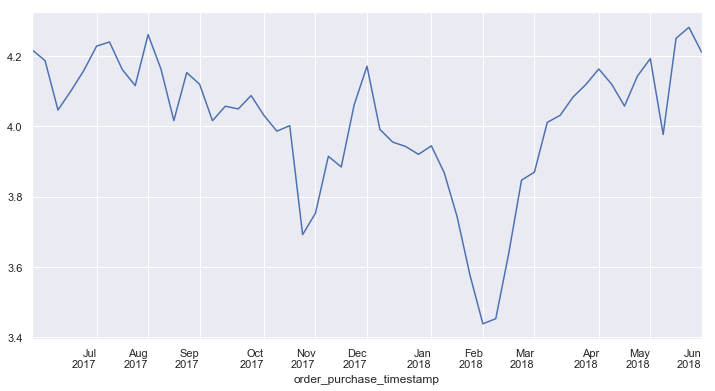

In [133]:
timeseries_plot(customers, 'order_purchase_timestamp', 'review_score', np.mean, dStart, dEnd, 'W')

> The average review score drops during high volume purchasing periods. We see a drop as shoppers buy for Christmas and a sharp drop in late february, corresponding to the increase in sales observed in the previous graph. The peak in profits around early May do not produce as sharp of a drop as during the two aforementioned periods but there is still an occurance. 

### When do customers write the most reviews?

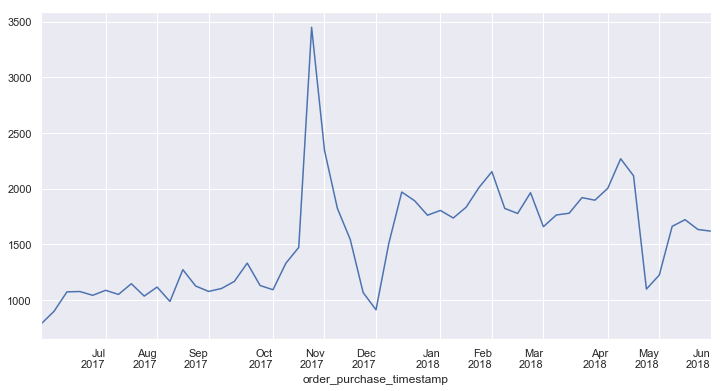

In [134]:
timeseries_vs_y = customers[['order_purchase_timestamp', 'review_comment_message']]
plot_df = timeseries_vs_y.set_index('order_purchase_timestamp').resample('W')['review_comment_message'].count()
#dStart = datetime.datetime(2017,1,1) # 1 May
#dEnd = datetime.datetime(2018,8,29) # 1 July
df = plot_df[(dStart <= plot_df.index) & (plot_df.index <= dEnd)]

ax = plt.figure(figsize=(12, 6)).add_subplot(111)   
xticks = pd.date_range(start=dStart, end=dEnd, freq='M')

df.plot(ax = ax, xticks = xticks)

ax.set_xticklabels([x.strftime('%h\n%Y') for x in xticks])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.show()


> Not suprisingly, the most reviews occur prior to the Christmas holiday with two other peaks related to the peak periods observed previously. 

### During what seasons are late delivery times the most significant?

In [135]:
#customers[customers['order_delivered_customer_date'] > customers['order_estimated_delivery_date']].count()
delivery_time = customers[['order_delivered_customer_date', 'order_estimated_delivery_date', 
                           'review_score', 'order_purchase_timestamp']]
delivery_time['on_time'] = (delivery_time['order_estimated_delivery_date']
                           >=
                           delivery_time['order_delivered_customer_date'])

delivery_time['diff_days'] = (delivery_time['order_delivered_customer_date']
                             -
                             delivery_time['order_estimated_delivery_date'])

delivery_time['diff_days'] = delivery_time['diff_days']/np.timedelta64(1, 'D')
delivery_time['satisfied'] = (delivery_time['review_score'] >= 3)

In [136]:
late_deliveries = delivery_time.loc[delivery_time['on_time'] == False]

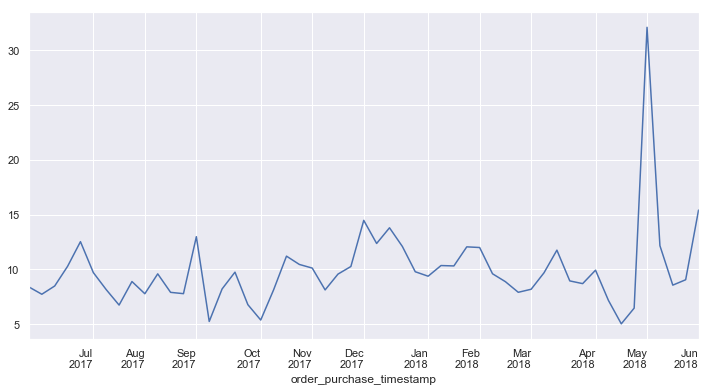

In [137]:
dStart = datetime.datetime(2017,7,1) # 1 May
dEnd = datetime.datetime(2018,7,1) # 1 July
timeseries_plot(late_deliveries, 'order_purchase_timestamp', 'diff_days', np.mean, dStart, dEnd, 'W')

> We see that the average lateness slightly increases relative to the high volume periods but more suprisingly there are larger differences seen during low volume periods. For example, there is a peak around January 1st, when sales dip dramatically. There is also a sharp increase at the end of May, around the same time there is a significant dip in profit. There is a possiblity that late delivery outliers could be pulling the average up for those low volume periods however.

### When are people most satisfied with their experience? How well does this correlate to on time deliveries?

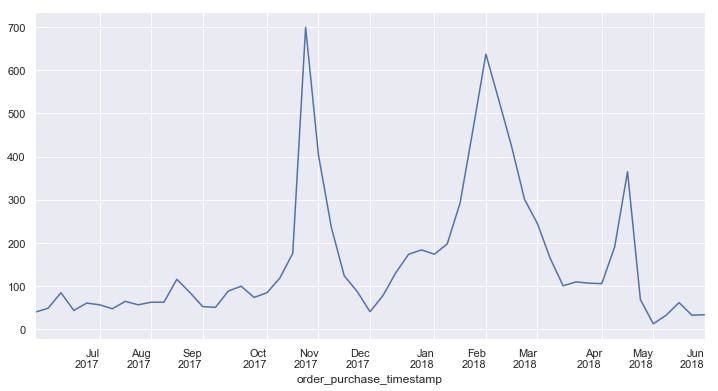

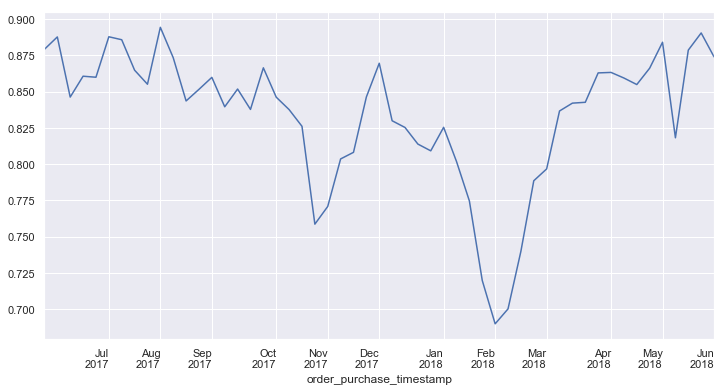

In [138]:
import matplotlib.dates as mdates
import datetime


plot1_df = late_deliveries.set_index('order_purchase_timestamp').resample('W')['on_time'].count()
plot2_df = delivery_time.set_index('order_purchase_timestamp').resample('W')['satisfied'].apply(np.mean)
dStart = datetime.datetime(2017,7,1) # 1 May
dEnd = datetime.datetime(2018,7,1) # 1 July
df1 = plot1_df[(dStart <= plot1_df.index) & (plot1_df.index <= dEnd)]
df2 = plot2_df[(dStart <= plot2_df.index) & (plot2_df.index <= dEnd)]

ax = plt.figure(figsize=(12, 6)).add_subplot(111)
ax2 = plt.figure(figsize=(12, 6)).add_subplot(111)
xticks = pd.date_range(start=dStart, end=dEnd, freq='M')

df1.plot(ax = ax, xticks = xticks)
df2.plot(ax = ax2, xticks = xticks)

ax.set_xticklabels([x.strftime('%h\n%Y') for x in xticks])
ax2.set_xticklabels([x.strftime('%h\n%Y') for x in xticks])
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
plt.setp(ax2.xaxis.get_majorticklabels(), ha='right')

plt.show()

> There is clearly a relationship between customer satisfaction and on-time delivery. The number of satisfied customers dip dramatically for the three main high volume periods.

## Create master df

In [139]:
customers.columns

Index(['order_id', 'customer_id', 'order_purchase_timestamp',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'geolocation_lat', 'geolocation_lng', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

In [140]:
sellers.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'geolocation_lat', 'geolocation_lng'],
      dtype='object')

In [141]:
sellers_selected = sellers[['order_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']]

In [142]:
master_df = customers.merge(sellers_selected, on ='order_id', ).drop(['order_delivered_customer_date', 
                                                          'order_estimated_delivery_date', 'shipping_limit_date',
                                                         'freight_value', 'review_comment_title', 'review_creation_date', 
                                                          'review_answer_timestamp', 'geolocation_lat', 'geolocation_lng',
                                                         'product_name_lenght', 'product_description_lenght', 'product_length_cm',
                                                          'product_height_cm', 'product_width_cm', 'review_id'], axis=1)

In [143]:
master_df.head()

,order_id,customer_id,order_purchase_timestamp,order_item_id,product_id,seller_id,price,review_score,review_comment_message,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_photos_qty,product_weight_g,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,4,"Não testei o produto ainda, mas ele veio corre...",7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,housewares,4.0,500.0,9350,maua,SP
1,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,2017-10-23 23:26:46,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,3,no comment given,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,housewares,4.0,500.0,9350,maua,SP
2,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,2017-08-15 18:29:31,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,4,Deveriam embalar melhor o produto. A caixa vei...,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,housewares,4.0,500.0,9350,maua,SP
3,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,2017-08-02 18:24:47,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,29.99,5,"Só achei ela pequena pra seis xícaras ,mais é ...",ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,housewares,4.0,500.0,9350,maua,SP
4,70b35acffdf851e782ebf6fbc35eb620,8e8ee9b08afb49b080d193f98b0505af,2018-03-22 17:23:21,1,6cc44821f36f3156c782da72dd634e47,da8622b14eb17ae2831f4ac5b9dab84a,99.90,5,Nâo sabia da entrega aos domingos pelo correio...,8a4002923e801e3120a11070fd31c9e2,3149,sao paulo,SP,bed_bath_table,1.0,1050.0,13405,piracicaba,SP


In [144]:
master_df.to_csv(r'/Users/mattmerrill/Springboard/Capstone2/olist_datascience/exploration/olist_data/master_df.csv', index=True)

In [145]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156066 entries, 0 to 156065
Data columns (total 19 columns):
order_id                    156066 non-null object
customer_id                 156066 non-null object
order_purchase_timestamp    156066 non-null datetime64[ns]
order_item_id               156066 non-null int64
product_id                  156066 non-null object
seller_id                   156066 non-null object
price                       156066 non-null float64
review_score                156066 non-null int64
review_comment_message      156066 non-null object
customer_unique_id          156066 non-null object
customer_zip_code_prefix    156066 non-null int64
customer_city               156066 non-null object
customer_state              156066 non-null object
product_category_name       156066 non-null object
product_photos_qty          156066 non-null float64
product_weight_g            156066 non-null float64
seller_zip_code_prefix      156066 non-null int64
seller_city    

## Recommender system using LightFM (work from week of 8/10)

### Data preprocessing:

**Metadata:**

We want to begin by extracting information about each product with at least one review. More general information will also be required about each product, such as the average review score, the number of messages and number of reviews. This will be done by pulling columns from the cleaned sellers df created in the data cleaning section of this report.

Following this we will group the product descriptions into bins to generalize for the model using pandas cut and qcut.

### Create user-item and item feature dataframes

In [186]:
user_item = master_df[['customer_id', 'customer_unique_id', 'product_id', 'review_score', 'order_purchase_timestamp']]
user_features = master_df[['customer_unique_id', 'customer_city', 'customer_state']]
item_features = master_df[['customer_unique_id','product_id', 'customer_id', 'product_category_name', 'seller_id', 'review_score', 
                          'review_comment_message', 'seller_city', 'seller_state', 'price', 'order_id', 'order_item_id']]

In [187]:
item_features = item_features.drop_duplicates(['customer_id','order_id', 'order_item_id']).reset_index(drop=True)

In [188]:
# to avoid counting a review comment labeled 'no comment given', we will convert them back to NAN
item_features['review_comment_message'] = item_features.review_comment_message\
                                                               .replace('no comment given', np.nan)

# create average review score column 
item_features['avg_product_score'] = item_features['review_score']\
                                                                 .groupby(item_features['product_id'])\
                                                                 .transform('mean')
# create average review score column 
item_features['avg_seller_score'] = item_features['review_score']\
                                                                 .groupby(item_features['seller_id'])\
                                                                 .transform('mean')

# create average review score column 
item_features['num_comments'] = item_features['review_comment_message']\
                                                                       .groupby(item_features['product_id'])\
                                                                       .transform('count')

# create average review score column 
item_features['num_reviews'] = item_features['review_score']\
                                                            .groupby(item_features['product_id'])\
                                                            .transform('count')

In [189]:
# create average price column
item_features['avg_price'] = item_features[['price']]\
                                                     .groupby(item_features['product_id'])\
                                                     .transform('mean')

In [190]:
# Create product_count column for the rating
item_features['product_count'] = item_features['product_id']\
                                                            .groupby(item_features['customer_unique_id'])\
                                                            .transform('count')

In [191]:
item_features['log_avg_price'] = np.log1p(item_features['avg_price'])

In [192]:
item_features['log_num_reviews'] = np.log1p(item_features['num_reviews'])
item_features['log_num_comments'] = np.log1p(item_features['num_comments'])

In [193]:
# use cut to group the same number of reviews in each section
item_features['num_reviews_binned'] = pd.cut(item_features['log_num_reviews'], 7, duplicates = 'drop')
item_features['num_comments_binned'] = pd.cut(item_features['log_num_comments'], 6, duplicates = 'drop')

# 
item_features['avg_product_reviews_binned'] = pd.cut(item_features['avg_product_score'], 4, duplicates = 'drop')
item_features['avg_seller_reviews_binned'] = pd.cut(item_features['avg_seller_score'], 4, duplicates = 'drop')

item_features['avg_price_binned'] = pd.qcut(item_features['avg_price'], 4, duplicates = 'drop')

In [194]:
item_features = item_features.sort_values('customer_unique_id').reset_index(drop=True)

In [195]:
cols = ['num_reviews_binned', 'num_comments_binned','avg_product_reviews_binned', 
        'avg_seller_reviews_binned', 'avg_price_binned']
for col in cols:
    item_features[col] = item_features[col].astype(str)

In [196]:
item_features.to_csv(r'/Users/mattmerrill/Springboard/Capstone2/olist_datascience/exploration/item_features.csv', index=True)

In [197]:
item_features.head()

,customer_unique_id,product_id,customer_id,product_category_name,seller_id,review_score,review_comment_message,seller_city,seller_state,price,...,avg_price,product_count,log_avg_price,log_num_reviews,log_num_comments,num_reviews_binned,num_comments_binned,avg_product_reviews_binned,avg_seller_reviews_binned,avg_price_binned
0,0000366f3b9a7992bf8c76cfdf3221e2,372645c7439f9661fbbacfd129aa92ec,fadbb3709178fc513abc1b2670aa1ad2,bed_bath_table,da8622b14eb17ae2831f4ac5b9dab84a,5,"Adorei a cortina, ficou linda na minha sala, e...",piracicaba,SP,129.90,...,109.382759,1,4.703954,3.401197,2.397895,"(3.081, 3.877]","(1.835, 2.753]","(4.0, 5.0]","(4.0, 5.0]","(74.9, 135.833]"
1,0000b849f77a49e4a4ce2b2a4ca5be3f,5099f7000472b634fea8304448d20825,4cb282e167ae9234755102258dd52ee8,health_beauty,138dbe45fc62f1e244378131a6801526,4,NaN,sao paulo,SP,18.90,...,19.042857,1,2.997873,2.079442,0.693147,"(1.489, 2.285]","(-0.00551, 0.918]","(4.0, 5.0]","(3.0, 4.0]","(0.849, 39.9]"
2,0000f46a3911fa3c0805444483337064,64b488de448a5324c4134ea39c28a34b,9b3932a6253894a02c1df9d19004239f,stationery,3d871de0142ce09b7081e2b9d1733cb1,3,NaN,campo limpo paulista,SP,69.00,...,73.000000,1,4.304065,1.791759,1.098612,"(1.489, 2.285]","(0.918, 1.835]","(4.0, 5.0]","(4.0, 5.0]","(39.9, 74.9]"
3,0000f6ccb0745a6a4b88665a16c9f078,2345a354a6f2033609bbf62bf5be9ef6,914991f0c02ef0843c0e7010c819d642,telephony,ef506c96320abeedfb894c34db06f478,4,Bom vendedor,sao paulo,SP,25.99,...,27.990000,1,3.366951,1.386294,1.098612,"(0.688, 1.489]","(0.918, 1.835]","(4.0, 5.0]","(3.0, 4.0]","(0.849, 39.9]"
4,0004aac84e0df4da2b147fca70cf8255,c72e18b3fe2739b8d24ebf3102450f37,47227568b10f5f58a524a75507e6992c,telephony,70a12e78e608ac31179aea7f8422044b,5,NaN,jacarei,SP,180.00,...,180.000000,1,5.198497,0.693147,0.000000,"(0.688, 1.489]","(-0.00551, 0.918]","(4.0, 5.0]","(3.0, 4.0]","(135.833, 6735.0]"


In [157]:
def get_user_list(df, user_column):
    """
    
    creating a list of user from dataframe df, user_column is a column 
    consisting of users in the dataframe df
    
    """
    
    return np.sort(df[user_column].unique())

def get_item_list(df, item_name_column):
    
    """
    
    creating a list of items from dataframe df, item_column is a column 
    consisting of items in the dataframe df
    
    return to item_id_list and item_id2name_mapping
    
    """
    
    item_list = df[item_name_column].unique()
    
    
    return item_list

def get_item_feature_list(df, product_category_col, seller_col, seller_rating_col, product_rating_col, 
                          num_comments, num_reviews, avg_price, seller_city, seller_state):
    
    categories = df[product_category_col]
    sellers = df[seller_col]
    seller_ratings = df[seller_rating_col]
    product_ratings = df[product_rating_col]
    num_product_comments = df[num_comments]
    num_product_reviews = df[num_reviews]
    avg_product_price = df[avg_price]
    seller_city = df[seller_city]
    seller_state = df[seller_state]
    
    return pd.concat([categories, sellers, seller_ratings, product_ratings, num_product_comments, 
                      num_product_reviews, avg_product_price, seller_city, seller_state], ignore_index = True).unique()

def get_user_feature_list(df, cluster_id, customer_state):
    
    customer_state = df[customer_state]
    cluster_id = df[cluster_id]
    
    return pd.concat([cluster_id, customer_state], ignore_index = True).unique()


### Add clustered groupings to user_features

In [158]:
item_features_clustered = pd.read_csv('/Users/mattmerrill/Springboard/Capstone2/olist_datascience/exploration/item_features_clustered.csv', index_col = 0)

In [159]:
user_features = pd.merge(user_features, item_features_clustered[['customer_unique_id', 'cluster_id']], 
        on = 'customer_unique_id', 
        how='left').drop('customer_city', axis=1)

In [160]:
user_features = user_features.dropna()

In [161]:
# create the user, item, feature lists
users = get_user_list(user_item, "customer_unique_id")
items = get_item_list(item_features, "product_id")
item_features_list = get_item_feature_list(item_features, "product_category_name", "seller_id", "avg_seller_reviews_binned",
                                           "avg_product_reviews_binned", "num_comments_binned", "num_reviews_binned", 
                                           "avg_price_binned", "seller_city", "seller_state")
user_features_list = get_user_feature_list(user_features, "cluster_id", "customer_state")

In [167]:
item_features_clustered.head()

,customer_unique_id,customer_id,product_id,order_id,product_category_name,order_item_id,seller_id,review_score,review_comment_message,seller_city,seller_state,price,product_category_count,cluster_id,cluster_id_2
0,7c396fd4830fd04220f754e42b4e5bff,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,e481f51cbdc54678b7cc49136f2d6af7,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,4,"Não testei o produto ainda, mas ele veio corre...",maua,SP,29.99,1,12,0
1,7c396fd4830fd04220f754e42b4e5bff,31f31efcb333fcbad2b1371c8cf0fa84,9abb00920aae319ef9eba674b7d2e6ff,69923a4e07ce446644394df37a710286,baby,1,1771297ac436903d1dd6b0e9279aa505,5,O produto está ok e foi entregue bem antes do ...,guarulhos,SP,35.39,1,12,0
2,e781fdcc107d13d865fc7698711cc572,53904ddbea91e1e92b2b3f1d09a7af86,87285b34884572647811a353c7ac498a,bfc39df4f36c3693ff3b63fcbea9e90a,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,3,no comment given,maua,SP,29.99,1,3,0
3,3a51803cc0d012c3b5dc8b7528cb05f7,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,128e10d95713541c87cd1a2e48201934,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,4,Deveriam embalar melhor o produto. A caixa vei...,maua,SP,29.99,1,3,0
4,ef0996a1a279c26e7ecbd737be23d235,26c7ac168e1433912a51b924fbd34d34,87285b34884572647811a353c7ac498a,0e7e841ddf8f8f2de2bad69267ecfbcf,housewares,1,3504c0cb71d7fa48d967e0e4c94d59d9,5,"Só achei ela pequena pra seis xícaras ,mais é ...",maua,SP,29.99,1,3,0


In [200]:
def id_mappings(user_list, item_list, item_feature_list, user_feature_list):
    """
    
    Create id mappings to convert user_id, item_id, and feature_id
    
    """
    user_to_index_mapping = {}
    index_to_user_mapping = {}
    for user_index, user_id in enumerate(user_list):
        user_to_index_mapping[user_id] = user_index
        index_to_user_mapping[user_index] = user_id
        
    item_to_index_mapping = {}
    index_to_item_mapping = {}
    for item_index, item_id in enumerate(item_list):
        item_to_index_mapping[item_id] = item_index
        index_to_item_mapping[item_index] = item_id
        
    item_feature_to_index_mapping = {}
    index_to_item_feature_mapping = {}
    for item_feature_index, item_feature_id in enumerate(item_feature_list):
        item_feature_to_index_mapping[item_feature_id] = item_feature_index
        index_to_item_feature_mapping[item_feature_index] = item_feature_id

    user_feature_to_index_mapping = {}
    index_to_user_feature_mapping = {}
    for user_feature_index, user_feature_id in enumerate(user_feature_list):
        user_feature_to_index_mapping[user_feature_id] = user_feature_index
        index_to_user_feature_mapping[user_feature_index] = user_feature_id
        
        
    return user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           item_feature_to_index_mapping, index_to_item_feature_mapping, \
           user_feature_to_index_mapping, index_to_user_feature_mapping

__Items dictionary__

This df will be used to associate each product with it's corresponding features. This will be used to to improve the output of the recommender system, which will produce a recommended product_id (specifying a specific product) with it's corresponding product category.

In [201]:
# generate mapping, LightFM library can't read other than (integer) index
user_to_index_mapping, index_to_user_mapping, \
           item_to_index_mapping, index_to_item_mapping, \
           item_feature_to_index_mapping, index_to_item_feature_mapping, \
           user_feature_to_index_mapping, index_to_user_feature_mapping = id_mappings(users, items, item_features_list, 
                                                                            user_features_list)

In [202]:
user_to_index_mapping

{'0000366f3b9a7992bf8c76cfdf3221e2': 0,
 '0000b849f77a49e4a4ce2b2a4ca5be3f': 1,
 '0000f46a3911fa3c0805444483337064': 2,
 '0000f6ccb0745a6a4b88665a16c9f078': 3,
 '0004aac84e0df4da2b147fca70cf8255': 4,
 '0004bd2a26a76fe21f786e4fbd80607f': 5,
 '00050ab1314c0e55a6ca13cf7181fecf': 6,
 '00053a61a98854899e70ed204dd4bafe': 7,
 '0005e1862207bf6ccc02e4228effd9a0': 8,
 '0005ef4cd20d2893f0d9fbd94d3c0d97': 9,
 '0006fdc98a402fceb4eb0ee528f6a8d4': 10,
 '00082cbe03e478190aadbea78542e933': 11,
 '00090324bbad0e9342388303bb71ba0a': 12,
 '000949456b182f53c18b68d6babc79c1': 13,
 '000a5ad9c4601d2bbdd9ed765d5213b3': 14,
 '000bfa1d2f1a41876493be685390d6d3': 15,
 '000c8bdb58a29e7115cfc257230fb21b': 16,
 '000d460961d6dbfa3ec6c9f5805769e1': 17,
 '000de6019bb59f34c099a907c151d855': 18,
 '000e309254ab1fc5ba99dd469d36bdb4': 19,
 '000ec5bff359e1c0ad76a81a45cb598f': 20,
 '000ed48ceeb6f4bf8ad021a10a3c7b43': 21,
 '000fbf0473c10fc1ab6f8d2d286ce20c': 22,
 '0010a452c6d13139e50b57f19f52e04e': 23,
 '0010fb34b966d44409382af9

In [171]:
product_to_feature = item_features[['product_id', 'product_category_name', 'seller_id', 'num_reviews_binned', 
                                    'num_comments_binned', 'avg_product_reviews_binned', 'avg_seller_reviews_binned',
                                    'avg_price_binned', 'seller_city', 'seller_state']]

In [172]:
user_to_product_rating = item_features[['customer_unique_id', 'product_id', 'product_count']]

In [173]:
user_to_product_rating = user_to_product_rating.sort_values(by='customer_unique_id').reset_index(drop=True)

__Train, test split__

In [174]:
import random
np.random.seed(31)

rows = np.random.binomial(1, .8, size=len(user_to_product_rating)).astype('bool')

user_to_product_rating_train = user_to_product_rating[rows].reset_index(drop=True)
user_to_product_rating_test = user_to_product_rating[~rows].reset_index(drop=True)

__Product-feature interactions df:__

We want to now create a dataframe that describes the relationship between product and features.

In [175]:
product_to_feature = product_to_feature.drop_duplicates('product_id').reset_index(drop=True)

In [176]:
# Transpose product_to_feature to extract features for each product_id
df = product_to_feature.set_index('product_id').T.reset_index(drop=True)

In [177]:
# Need to create list of product_id's repeated 6 times for each feauture the resulting df will hold
cols = list(df.columns)
res =  [ele for ele in cols for i in range(len(product_to_feature.columns) - 1)]

In [178]:
# Create empty dataframe with index as product_id
features = pd.DataFrame(index = res)
features.index.name = 'product_id'

# Reset index so 'product_id' becomes column
features = features.reset_index()

# create empty column to fill
features['feature'] = ""

In [179]:
# Create list of feature items to replace empty column
feature_items = []
for col in cols:
    for i in range(len(product_to_feature.columns) - 1):
        feature_items.append(df[col][i])

In [180]:
features['feature'] = feature_items

In [181]:
product_to_feature = features

In [182]:
product_to_feature['feature_count'] = 1

In [183]:
product_to_feature.head(10)

,product_id,feature,feature_count
0,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,1
1,372645c7439f9661fbbacfd129aa92ec,da8622b14eb17ae2831f4ac5b9dab84a,1
2,372645c7439f9661fbbacfd129aa92ec,"(3.081, 3.877]",1
3,372645c7439f9661fbbacfd129aa92ec,"(1.835, 2.753]",1
4,372645c7439f9661fbbacfd129aa92ec,"(4.0, 5.0]",1
5,372645c7439f9661fbbacfd129aa92ec,"(4.0, 5.0]",1
6,372645c7439f9661fbbacfd129aa92ec,"(4.0, 5.0]",1
7,372645c7439f9661fbbacfd129aa92ec,piracicaba,1
8,372645c7439f9661fbbacfd129aa92ec,SP,1
9,5099f7000472b634fea8304448d20825,health_beauty,1


__User-feature interaction df__

In [184]:
user_to_feature = user_features.drop_duplicates('customer_unique_id').reset_index(drop=True)

In [185]:
# Transpose product_to_feature to extract features for each customer
df = user_to_feature.set_index('customer_unique_id').T.reset_index(drop=True)

In [186]:
df.head()

customer_unique_id,7c396fd4830fd04220f754e42b4e5bff,e781fdcc107d13d865fc7698711cc572,3a51803cc0d012c3b5dc8b7528cb05f7,ef0996a1a279c26e7ecbd737be23d235,8a4002923e801e3120a11070fd31c9e2,0cad1c6c08ef74b3ae7818514c158258,eb5c27c09badfe9c053416ca5c3c7c35,6eff1cd9cc7f4dde6e1cbb679e219a50,cc3f5d537772957f90b7f15f1fb70316,87c9eb971f4cfcbefa08cb27b21bc9a7,...,17cb19c8526583b203e7a3a6c828d3aa,7ce47ba6982b3ce9bee72ab948481f9e,f9ccc64481a04c1a9886994895b97f03,78a159045124eb7601951b917a42034f,f5138d94d7e1085c5219408f32b62529,8b8c8f067a3faaf116211277147a88de,1ef6a1d949703afd7a74347aed3b0503,ebc6df639d125e446f07c0e9b1e47b90,ed81a42bec90c87578108d2e4c742d20,a49e8e11e850592fe685ae3c64b40eca
0,SP,SC,SP,SP,SP,SP,SP,RJ,SP,SP,...,PE,RS,PB,SC,SP,MG,TO,MG,BA,PR
1,12,3,3,3,2,2,2,2,2,2,...,4,7,7,7,3,9,14,13,7,0


In [187]:
# Need to create list of product_id's repeated 6 times for each feauture the resulting df will hold
cols = list(df.columns)
res =  [ele for ele in cols for i in range(len(user_to_feature.columns)-1)]

In [188]:
# Create empty dataframe with index as product_id
user_feature = pd.DataFrame(index = res)
user_feature.index.name = 'customer_unique_id'

# Reset index so 'product_id' becomes column
user_feature = user_feature.reset_index()

# create empty column to fill
user_feature['feature'] = ""

In [189]:
# Create list of feature items to replace empty column
feature_items = []
for col in cols:
    for i in range(len(user_to_feature.columns)-1):
        feature_items.append(df[col][i])

In [190]:
user_feature['feature'] = feature_items

In [191]:
user_to_feature = user_feature

In [192]:
user_to_feature['feature_count'] = 1

__Final interaction dfs__

In [193]:
product_to_feature.head()

,product_id,feature,feature_count
0,372645c7439f9661fbbacfd129aa92ec,bed_bath_table,1
1,372645c7439f9661fbbacfd129aa92ec,da8622b14eb17ae2831f4ac5b9dab84a,1
2,372645c7439f9661fbbacfd129aa92ec,"(3.081, 3.877]",1
3,372645c7439f9661fbbacfd129aa92ec,"(1.835, 2.753]",1
4,372645c7439f9661fbbacfd129aa92ec,"(4.0, 5.0]",1


In [194]:
user_to_feature.head()

,customer_unique_id,feature,feature_count
0,7c396fd4830fd04220f754e42b4e5bff,SP,1
1,7c396fd4830fd04220f754e42b4e5bff,12,1
2,e781fdcc107d13d865fc7698711cc572,SC,1
3,e781fdcc107d13d865fc7698711cc572,3,1
4,3a51803cc0d012c3b5dc8b7528cb05f7,SP,1


In [195]:
user_to_product_rating_train.head()

,customer_unique_id,product_id,product_count
0,0000366f3b9a7992bf8c76cfdf3221e2,372645c7439f9661fbbacfd129aa92ec,1
1,0000f46a3911fa3c0805444483337064,64b488de448a5324c4134ea39c28a34b,1
2,0004aac84e0df4da2b147fca70cf8255,c72e18b3fe2739b8d24ebf3102450f37,1
3,0004bd2a26a76fe21f786e4fbd80607f,25cf184645f3fae66083bf33581b8f13,1
4,00053a61a98854899e70ed204dd4bafe,58727e154e8e85d84052cd22b0136c84,2


In [196]:
user_to_product_rating_test.head()

,customer_unique_id,product_id,product_count
0,0000b849f77a49e4a4ce2b2a4ca5be3f,5099f7000472b634fea8304448d20825,1
1,0000f6ccb0745a6a4b88665a16c9f078,2345a354a6f2033609bbf62bf5be9ef6,1
2,00050ab1314c0e55a6ca13cf7181fecf,8cefe1c6f2304e7e6825150218ffc58c,1
3,000de6019bb59f34c099a907c151d855,af0a917aec9cea3b353ece61a8825326,2
4,000ed48ceeb6f4bf8ad021a10a3c7b43,d2f5484cbffe4ca766301b21ab9246dd,1


__Create sparse matrix for products and metadata__

In [197]:
from scipy import sparse
def get_interaction_matrix(df, df_column_as_row, df_column_as_col, df_column_as_value, row_indexing_map, 
                          col_indexing_map):
    
    row = df[df_column_as_row].apply(lambda x: row_indexing_map[x]).values
    col = df[df_column_as_col].apply(lambda x: col_indexing_map[x]).values
    value = df[df_column_as_value].values
    
    return sparse.coo_matrix((value, (row, col)), shape = (len(row_indexing_map), len(col_indexing_map)))

In [198]:
# generate user_item_interaction_matrix for train data
user_to_product_interaction_train = get_interaction_matrix(user_to_product_rating_train, "customer_unique_id", 
                                                    "product_id", "product_count", user_to_index_mapping, item_to_index_mapping)

# generate user_item_interaction_matrix for test data
user_to_product_interaction_test = get_interaction_matrix(user_to_product_rating_test, "customer_unique_id", 
                                                    "product_id", "product_count", user_to_index_mapping, item_to_index_mapping)

# generate item_to_feature interaction
product_to_feature_interaction = get_interaction_matrix(product_to_feature, "product_id", "feature",  "feature_count", 
                                                        item_to_index_mapping, item_feature_to_index_mapping)

user_to_feature_interaction = get_interaction_matrix(user_to_feature, "customer_unique_id", "feature", "feature_count", 
                                                     user_to_index_mapping, user_feature_to_index_mapping)

## Model with only user-product interactions

In [199]:
import time
from lightfm import LightFM
from lightfm.evaluation import auc_score
# initialising model with warp loss function
model_without_features = LightFM(loss = "warp")

# fitting into user to product interaction matrix only / pure collaborative filtering factor
start = time.time()
#===================

model_without_features.fit(user_to_product_interaction_train,
          user_features=None, 
          item_features=None, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

# auc metric score (ranging from 0 to 1)

start = time.time()
#===================

auc_without_features = auc_score(model = model_without_features, 
                        test_interactions = user_to_product_interaction_test,
                        num_threads = 4, check_intersections = False)
#===================
end = time.time()

print("time taken = {0:.{1}f} seconds".format(end - start, 2))
print("average AUC without adding item-feature interaction = {0:.{1}f}".format(auc_without_features.mean(), 2))

/Users/mattmerrill/opt/anaconda3/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning:

LightFM was compiled without OpenMP support. Only a single thread will be used.



time taken = 0.15 seconds
time taken = 24.05 seconds
average AUC without adding item-feature interaction = 0.68


## Model with hybrid collaborative filtering and content based

In [200]:
# initialising model with warp loss function
model_with_features = LightFM(loss = "warp")

# fitting the model with hybrid collaborative filtering + content based (product + features)
start = time.time()
#===================


model_with_features.fit(user_to_product_interaction_train,
          user_features=None, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

start = time.time()
#===================
auc_with_features = auc_score(model = model_with_features, 
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train,
                        user_features=None,
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

print("average AUC with adding item-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))


time taken = 0.25 seconds
time taken = 60.58 seconds
average AUC with adding item-feature interaction = 0.79


> Much better results with including product interactions. This makes sense here due to the fact that many of the customers in this dataset have only bought from olist one time. 

> 2 percent increase after adding average price, seller city and seller state

## Model with hybrid collaborative filtering and content based including user features

In [202]:
import time
from lightfm import LightFM
from lightfm.evaluation import auc_score
# initialising model with warp loss function
model_with_features_and_users = LightFM(loss = "warp")

# fitting the model with hybrid collaborative filtering + content based (product + features)
start = time.time()
#===================


model_with_features_and_users.fit(user_to_product_interaction_train,
          user_features=user_to_feature_interaction, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

start = time.time()
#===================
auc_with_features = auc_score(model = model_with_features_and_users, 
                        test_interactions = user_to_product_interaction_test,
                        train_interactions = user_to_product_interaction_train,
                        user_features=user_to_feature_interaction,
                        item_features = product_to_feature_interaction,
                        num_threads = 4, check_intersections=False)
#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

print("average AUC with adding item-feature and user-feature interaction = {0:.{1}f}".format(auc_with_features.mean(), 2))


time taken = 0.22 seconds
time taken = 61.46 seconds
average AUC with adding item-feature and user-feature interaction = 0.97


> drops 3 percent when adding user features with customer city and state

> When adding clustering groups the auc increases to 97, which indicates some overfitting going on here. The clustering groups may be too heavily relied on for recommendations.

In [203]:
def combined_train_test(train, test):
    """
    
    test set is the more recent rating/number_of_order of users.
    train set is the previous rating/number_of_order of users.
    non-zero value in the test set will replace the elements in 
    the train set matrices
    """
    # initialising train dict
    train_dict = {}
    for train_row, train_col, train_data in zip(train.row, train.col, train.data):
        train_dict[(train_row, train_col)] = train_data
        
    # replacing with the test set
    
    for test_row, test_col, test_data in zip(test.row, test.col, test.data):
        train_dict[(test_row, test_col)] = max(test_data, train_dict.get((test_row, test_col), 0))
        
    
    # converting to the row
    row_element = []
    col_element = []
    data_element = []
    for row, col in train_dict:
        row_element.append(row)
        col_element.append(col)
        data_element.append(train_dict[(row, col)])
        
    # converting to np array
    
    row_element = np.array(row_element)
    col_element = np.array(col_element)
    data_element = np.array(data_element)
    
    return sparse.coo_matrix((data_element, (row_element, col_element)), shape = (train.shape[0], train.shape[1]))

In [204]:
user_to_product_interaction = combined_train_test(user_to_product_interaction_train, 
                                                 user_to_product_interaction_test)

In [205]:
# retraining the final model with combined dataset

initial_model1 = LightFM(loss = "warp")

# fitting to combined dataset with pure collaborative filtering result

start = time.time()
#===================

initial_model1.fit(user_to_product_interaction,
          user_features=None, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 0.30 seconds


In [206]:
# retraining the final model with combined dataset

initial_model2 = LightFM(loss = "warp")

# fitting to combined dataset with pure collaborative filtering result

start = time.time()
#===================

initial_model2.fit(user_to_product_interaction,
          user_features=user_to_feature_interaction, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=1, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 0.27 seconds


__Define recommendation function__

This function should provide the requested number of recommended items given a customers id. For reproducibility it will take the model, customer-product interaction, and the customer and item dictionaries. The function will print the known items liked by the customer, and will output the top n recommended items based on their history. 

In [230]:
class recommendation_sampling:
    
    def __init__(self, model, items = items, user_to_product_interaction_matrix = user_to_product_interaction, 
                user2index_map = user_to_index_mapping):
        
        self.user_to_product_interaction_matrix = user_to_product_interaction_matrix
        self.model = model
        self.items = items
        self.user2index_map = user2index_map
    
    def recommendation_for_user(self, user, user_features=None):
        
        # getting the userindex
        
        userindex = self.user2index_map.get(user, None)
        
        if userindex == None:
            return None
        
        users = [userindex]
        
        # products already bought
        
        known_positives = self.items[self.user_to_product_interaction_matrix.tocsr()[userindex].indices]
        
        # scores from model prediction
        scores = self.model.predict(user_ids = users, item_ids = np.arange(self.user_to_product_interaction_matrix.shape[1]),
                                    user_features=user_features,
                                    item_features = product_to_feature_interaction)

        # top items
        
        top_items = self.items[np.argsort(-scores)]
        
        # printing out the result
        print("User %s" % user)
        print("     Known positives:")
        
        for x in known_positives[:3]:
            print("                  %s" % x)
            print("                  {}".format(product_to_feature['feature'][product_to_feature['product_id'] == x].iloc[0]))
            
            
        print("     Recommended:")
        
        for x in top_items[:3]:
            print("                  %s" % x)
            print("                  {}".format(product_to_feature['feature'][product_to_feature['product_id'] == x].iloc[0]))

__Test for customer_id = 'c8ed31310fc440a3f8031b177f9842c3'__

In [231]:
recom = recommendation_sampling(model = initial_model1)
print(recom.recommendation_for_user('c8ed31310fc440a3f8031b177f9842c3'))

User c8ed31310fc440a3f8031b177f9842c3
     Known positives:
                  4a5c3967bfd3629fe07ef4d0cc8c3818
                  construction_tools_construction
                  21b524c4c060169fa75ccf08c7da4627
                  construction_tools_construction
                  5dae498eff2d80057f56122235a36aff
                  construction_tools_construction
     Recommended:
                  93a12c289ca2b78e7069e469f5053ef2
                  computers_accessories
                  e53e557d5a159f5aa2c5e995dfdf244b
                  computers_accessories
                  cd46a885543f0e169a49f1eb25c04e43
                  computers_accessories
None


In [209]:
recom = recommendation_sampling(model = initial_model2)
print(recom.recommendation_for_user('c8ed31310fc440a3f8031b177f9842c3', user_features=user_to_feature_interaction))

User c8ed31310fc440a3f8031b177f9842c3
     Known positives:
                  4a5c3967bfd3629fe07ef4d0cc8c3818
                  construction_tools_construction
                  21b524c4c060169fa75ccf08c7da4627
                  construction_tools_construction
                  5dae498eff2d80057f56122235a36aff
                  construction_tools_construction
     Recommended:
                  11fd9d7ba552e1d28872e008acf1e050
                  cool_stuff
                  4fe644d766c7566dbc46fb851363cb3b
                  art
                  0aabfb375647d9738ad0f7b4ea3653b1
                  consoles_games
None


## Implement hyperparameter tuning

In [211]:
import itertools

import numpy as np

from lightfm import LightFM
from lightfm.evaluation import auc_score


def sample_hyperparameters():
    """
    Yield possible hyperparameter choices.
    """

    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(5, 50),
        }


def random_search(test, train, user_features, item_features, num_samples=10):
    """
    Sample random hyperparameters, fit a LightFM model, and evaluate it
    on the test set.

    Parameters
    ----------

    train: np.float32 coo_matrix of shape [n_users, n_items]
        Training data.
    test: np.float32 coo_matrix of shape [n_users, n_items]
        Test data.
    num_samples: int, optional
        Number of hyperparameter choices to evaluate.


    Returns
    -------

    generator of (auc_score, hyperparameter dict, fitted model)

    """

    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        num_epochs = hyperparams.pop("num_epochs")

        model = LightFM(**hyperparams)
        model.fit(train, user_features=user_features, item_features=item_features, epochs=num_epochs, num_threads=1)

        score = auc_score(model = model, 
                        test_interactions = test,
                        train_interactions = train,
                        user_features = user_features,
                        item_features = item_features,
                        num_threads = 4, check_intersections=False).mean()

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [213]:
if __name__ == "__main__":
    
    (score, hyperparams1, model) = max(random_search(user_to_product_interaction_test,
                                                    user_to_product_interaction_train,
                                                    user_features=None,
                                                    item_features=product_to_feature_interaction), 
                                      key=lambda x: x[0])
    
    
    print("Best score {} at {}".format(score, hyperparams1))

Best score 0.7941246628761292 at {'no_components': 60, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.005731234319203985, 'item_alpha': 1.8324484381264776e-10, 'user_alpha': 2.284333742320558e-10, 'max_sampled': 6, 'num_epochs': 6}


In [214]:
if __name__ == "__main__":
    
    (score, hyperparams2, model) = max(random_search(user_to_product_interaction_test,
                                                    user_to_product_interaction_train,
                                                    user_to_feature_interaction,
                                                    product_to_feature_interaction), 
                                      key=lambda x: x[0])
    
    
    print("Best score {} at {}".format(score, hyperparams2))

Best score 0.9710936546325684 at {'no_components': 37, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.02632832718353252, 'item_alpha': 1.2246502291850314e-08, 'user_alpha': 1.0164351497493115e-08, 'max_sampled': 6, 'num_epochs': 5}


In [224]:
# retraining the final model with combined dataset
model_hyperparams1 = {key: value for key, value in hyperparams1.items() if key not in 'num_epochs'}
# without clustered label
final_model1 = LightFM(**(model_hyperparams1), random_state=3)

# fitting to combined dataset with pure collaborative filtering result

start = time.time()
#===================

final_model1.fit(user_to_product_interaction,
          user_features=None, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=5, 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 3.41 seconds


In [225]:
# retraining the final model with combined dataset
# with clustered label
model_hyperparams2 = {key: value for key, value in hyperparams2.items() if key not in 'num_epochs'}
final_model2 = LightFM(**model_hyperparams2, random_state=3)

# fitting to combined dataset with pure collaborative filtering result

start = time.time()
#===================

final_model2.fit(user_to_product_interaction,
          user_features=user_to_feature_interaction, 
          item_features=product_to_feature_interaction, 
          sample_weight=None, 
          epochs=hyperparams2.pop('num_epochs'), 
          num_threads=4,
          verbose=False)

#===================
end = time.time()
print("time taken = {0:.{1}f} seconds".format(end - start, 2))

time taken = 1.69 seconds


__Test for customer_id = 'c8ed31310fc440a3f8031b177f9842c3'__

In [226]:
recom = recommendation_sampling(model = final_model1)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('c8ed31310fc440a3f8031b177f9842c3'))

User c8ed31310fc440a3f8031b177f9842c3
     Known positives:
                  4a5c3967bfd3629fe07ef4d0cc8c3818
                  construction_tools_construction
                  21b524c4c060169fa75ccf08c7da4627
                  construction_tools_construction
                  5dae498eff2d80057f56122235a36aff
                  construction_tools_construction
     Recommended:
                  e53e557d5a159f5aa2c5e995dfdf244b
                  computers_accessories
                  656e0eca68dcecf6a31b8ececfabe3e8
                  computers_accessories
                  36f60d45225e60c7da4558b070ce4b60
                  computers_accessories
None


In [227]:
recom = recommendation_sampling(model = final_model2)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('c8ed31310fc440a3f8031b177f9842c3', user_features=user_to_feature_interaction))

User c8ed31310fc440a3f8031b177f9842c3
     Known positives:
                  4a5c3967bfd3629fe07ef4d0cc8c3818
                  construction_tools_construction
                  21b524c4c060169fa75ccf08c7da4627
                  construction_tools_construction
                  5dae498eff2d80057f56122235a36aff
                  construction_tools_construction
     Recommended:
                  11fd9d7ba552e1d28872e008acf1e050
                  cool_stuff
                  54d9ac713e253fa1fae9c8003b011c2a
                  cool_stuff
                  d017a2151d543a9885604dc62a3d9dcc
                  fashion_bags_accessories
None


> The initial results from our first run through of both models yields some interesting results. Our model without user features (which includes the clustered group) gives cool stuff and fashion bags for this user who bought only construction tools. 

In [232]:
recom = recommendation_sampling(model = final_model1)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('4546caea018ad8c692964e3382debd19'))

User 4546caea018ad8c692964e3382debd19
     Known positives:
                  05b515fdc76e888aada3c6d66c201dff
                  health_beauty
                  270516a3f41dc035aa87d220228f844c
                  health_beauty
                  79ce45dbc2ea29b22b5a261bbb7b7ee7
                  health_beauty
     Recommended:
                  89b121bee266dcd25688a1ba72eefb61
                  computers_accessories
                  b5e13c9a353102f79c6206ff5cb61a50
                  toys
                  0cf41187284d7f099adc8415a743ebbd
                  baby
None


In [233]:
recom = recommendation_sampling(model = final_model2)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('4546caea018ad8c692964e3382debd19', user_features=user_to_feature_interaction))

User 4546caea018ad8c692964e3382debd19
     Known positives:
                  05b515fdc76e888aada3c6d66c201dff
                  health_beauty
                  270516a3f41dc035aa87d220228f844c
                  health_beauty
                  79ce45dbc2ea29b22b5a261bbb7b7ee7
                  health_beauty
     Recommended:
                  6cdd53843498f92890544667809f1595
                  health_beauty
                  3fbc0ef745950c7932d5f2a446189725
                  health_beauty
                  7c1bd920dbdf22470b68bde975dd3ccf
                  health_beauty
None


In [234]:
#698e1cf81d01a3d389d96145f7fa6df8
recom = recommendation_sampling(model = final_model1)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('698e1cf81d01a3d389d96145f7fa6df8'))

User 698e1cf81d01a3d389d96145f7fa6df8
     Known positives:
                  9571759451b1d780ee7c15012ea109d4
                  auto
     Recommended:
                  53759a2ecddad2bb87a079a1f1519f73
                  garden_tools
                  422879e10f46682990de24d770e7f83d
                  garden_tools
                  368c6c730842d78016ad823897a372db
                  garden_tools
None


In [235]:
recom = recommendation_sampling(model = final_model2)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('698e1cf81d01a3d389d96145f7fa6df8', user_features=user_to_feature_interaction))

User 698e1cf81d01a3d389d96145f7fa6df8
     Known positives:
                  9571759451b1d780ee7c15012ea109d4
                  auto
     Recommended:
                  629e019a6f298a83aeecc7877964f935
                  auto
                  4fcb3d9a5f4871e8362dfedbdb02b064
                  auto
                  a50acd33ba7a8da8e9db65094fa990a4
                  auto
None


In [245]:
# 0f5ac8d5c31de21d2f25e24be15bbffb
recom = recommendation_sampling(model = final_model1)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('698e1cf81d01a3d389d96145f7fa6df8'))

User 698e1cf81d01a3d389d96145f7fa6df8
     Known positives:
                  9571759451b1d780ee7c15012ea109d4
                  auto
     Recommended:
                  53759a2ecddad2bb87a079a1f1519f73
                  garden_tools
                  422879e10f46682990de24d770e7f83d
                  garden_tools
                  368c6c730842d78016ad823897a372db
                  garden_tools
None


In [246]:
recom = recommendation_sampling(model = final_model2)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('0f5ac8d5c31de21d2f25e24be15bbffb', user_features=user_to_feature_interaction))

User 0f5ac8d5c31de21d2f25e24be15bbffb
     Known positives:
                  ff26009ac6b838dc6cffa2d589cdbefb
                  furniture_decor
                  89b190a046022486c635022524a974a8
                  furniture_decor
     Recommended:
                  aca2eb7d00ea1a7b8ebd4e68314663af
                  furniture_decor
                  78efe838c04bbc568be034082200ac20
                  furniture_decor
                  c1488892604e4ba5cff5b4eb4d595400
                  furniture_decor
None


In [257]:
recom = recommendation_sampling(model = final_model1)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('dc813062e0fc23409cd255f7f53c7074'))

User dc813062e0fc23409cd255f7f53c7074
     Known positives:
                  b623b7cb05ee3248fbe4a6ecbeed79a4
                  toys
                  423b46d7ff817b1cd19ab195c7b76546
                  watches_gifts
                  db12039c7ff4e850d48e0312fa9b3473
                  cool_stuff
     Recommended:
                  2028bf1b01cafb2d2b1901fca4083222
                  perfumery
                  ee0c1cf2fbeae95205b4aa506f1469f0
                  perfumery
                  8c591ab0ca519558779df02023177f44
                  garden_tools
None


In [258]:
recom = recommendation_sampling(model = final_model2)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('dc813062e0fc23409cd255f7f53c7074', user_features=user_to_feature_interaction))

User dc813062e0fc23409cd255f7f53c7074
     Known positives:
                  b623b7cb05ee3248fbe4a6ecbeed79a4
                  toys
                  423b46d7ff817b1cd19ab195c7b76546
                  watches_gifts
                  db12039c7ff4e850d48e0312fa9b3473
                  cool_stuff
     Recommended:
                  b5e13c9a353102f79c6206ff5cb61a50
                  toys
                  7f72a8900b3d2fc8fa2635b7836d6e6e
                  toys
                  dabbb10b2f36548cf2aff2993f4cf5e2
                  toys
None


### Customer "a3dc27d87234f862d7e61a0148c77fa9"

This customer only bought health and beauty products as well as drinks in their history.

In [260]:
# a3dc27d87234f862d7e61a0148c77fa9
recom = recommendation_sampling(model = final_model1)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('a3dc27d87234f862d7e61a0148c77fa9'))

User a3dc27d87234f862d7e61a0148c77fa9
     Known positives:
                  994ab76f0da3349fffcfe5d598e9babb
                  health_beauty
                  8fbf9021a217075b130d33b3485e8fb3
                  health_beauty
                  c2b534c5a4a6cbfc41aeaf362fb0c060
                  drinks
     Recommended:
                  e53e557d5a159f5aa2c5e995dfdf244b
                  computers_accessories
                  36f60d45225e60c7da4558b070ce4b60
                  computers_accessories
                  656e0eca68dcecf6a31b8ececfabe3e8
                  computers_accessories
None


In [261]:
recom = recommendation_sampling(model = final_model2)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('a3dc27d87234f862d7e61a0148c77fa9', user_features=user_to_feature_interaction))

User a3dc27d87234f862d7e61a0148c77fa9
     Known positives:
                  994ab76f0da3349fffcfe5d598e9babb
                  health_beauty
                  8fbf9021a217075b130d33b3485e8fb3
                  health_beauty
                  c2b534c5a4a6cbfc41aeaf362fb0c060
                  drinks
     Recommended:
                  6cdd53843498f92890544667809f1595
                  health_beauty
                  3fbc0ef745950c7932d5f2a446189725
                  health_beauty
                  7c1bd920dbdf22470b68bde975dd3ccf
                  health_beauty
None


### Customer "33176de67c05eeed870fd49f234387a0"

This customer bought only computer accessories and security products in their history. 

In [263]:
# 33176de67c05eeed870fd49f234387a0
recom = recommendation_sampling(model = final_model1)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('33176de67c05eeed870fd49f234387a0'))

User 33176de67c05eeed870fd49f234387a0
     Known positives:
                  70906e04da1eebf3d1b8791bd09ffe85
                  computers_accessories
                  0c8b6b6e4f9ee5fe2c48d6cee4c69bc8
                  signaling_and_security
                  2e511b5741ab14e7f5294df6f1310b03
                  computers_accessories
     Recommended:
                  368c6c730842d78016ad823897a372db
                  garden_tools
                  53759a2ecddad2bb87a079a1f1519f73
                  garden_tools
                  422879e10f46682990de24d770e7f83d
                  garden_tools
None


In [264]:
recom = recommendation_sampling(model = final_model2)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('33176de67c05eeed870fd49f234387a0', user_features=user_to_feature_interaction))

User 33176de67c05eeed870fd49f234387a0
     Known positives:
                  70906e04da1eebf3d1b8791bd09ffe85
                  computers_accessories
                  0c8b6b6e4f9ee5fe2c48d6cee4c69bc8
                  signaling_and_security
                  2e511b5741ab14e7f5294df6f1310b03
                  computers_accessories
     Recommended:
                  d1c427060a0f73f6b889a5c7c61f2ac4
                  computers_accessories
                  130482add9fd75ccb6c57ba007694a2d
                  computers_accessories
                  3dd2a17168ec895c781a9191c1e95ad7
                  computers_accessories
None


### Customer "89be58cbdd6ef318e3ed93fdb22be178" 

This customer only bought diapers/hygiene products in their history. The hope here would be for the engine to recommend baby products, however the duel nature of the category might suggest it is related to things other than baby products.

In [266]:
# 89be58cbdd6ef318e3ed93fdb22be178
recom = recommendation_sampling(model = final_model1)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('89be58cbdd6ef318e3ed93fdb22be178'))

User 89be58cbdd6ef318e3ed93fdb22be178
     Known positives:
                  3fdb534dccf5bc9ab0406944b913787d
                  diapers_and_hygiene
     Recommended:
                  89b121bee266dcd25688a1ba72eefb61
                  computers_accessories
                  d285360f29ac7fd97640bf0baef03de0
                  watches_gifts
                  461f43be3bdf8844e65b62d9ac2c7a5a
                  watches_gifts
None


In [267]:
recom = recommendation_sampling(model = final_model2)
#print(recom.recommendation_for_user(2))
print(recom.recommendation_for_user('89be58cbdd6ef318e3ed93fdb22be178', user_features=user_to_feature_interaction))

User 89be58cbdd6ef318e3ed93fdb22be178
     Known positives:
                  3fdb534dccf5bc9ab0406944b913787d
                  diapers_and_hygiene
     Recommended:
                  11fd9d7ba552e1d28872e008acf1e050
                  cool_stuff
                  54d9ac713e253fa1fae9c8003b011c2a
                  cool_stuff
                  d017a2151d543a9885604dc62a3d9dcc
                  fashion_bags_accessories
None


__Short conclusion__

I would guess there is some tuning to do here, this customer bought 10 construction type tools and my recommender suggested fashion bags as the top recommended item! Interesting, but more work is required here. 

In [265]:
item_features[['product_count', 'customer_unique_id', 'product_category_name']].sort_values\
                        (['product_count', 'customer_unique_id'])[-500:-450]

,product_count,customer_unique_id,product_category_name
21190,10,310647380793836bfa5b7b6b3f518423,bed_bath_table
21191,10,310647380793836bfa5b7b6b3f518423,bed_bath_table
21192,10,310647380793836bfa5b7b6b3f518423,computers_accessories
21193,10,310647380793836bfa5b7b6b3f518423,bed_bath_table
21194,10,310647380793836bfa5b7b6b3f518423,bed_bath_table
21195,10,310647380793836bfa5b7b6b3f518423,bed_bath_table
24518,10,38a4f1deb45ca914dd13c73b41775d71,furniture_living_room
24519,10,38a4f1deb45ca914dd13c73b41775d71,furniture_living_room
24520,10,38a4f1deb45ca914dd13c73b41775d71,furniture_living_room
24521,10,38a4f1deb45ca914dd13c73b41775d71,furniture_living_room
